In [64]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### 2. Data Preprocessing and EDA

In [65]:
# Making sure the file is readable by Pandas

with open('genius_hip_hop_lyrics.csv', 'r', encoding='utf-8', errors='ignore') as file:
    content = file.read()

with open('genius_hip_hop_lyrics_cleaned.csv', 'w', encoding='utf-8') as file:
    file.write(content)

hip_hop = pd.read_csv('genius_hip_hop_lyrics_cleaned.csv')

hip_hop = hip_hop.set_index('id')

hip_hop.head()

candidate             song       artist sentiment      theme  \
id                                                                     
1   Mike Huckabee  None Shall Pass   Aesop Rock   neutral        NaN   
2   Mike Huckabee        Wellstone    Soul Khan  negative        NaN   
3        Jeb Bush              Awe   Dez & Nobs   neutral        NaN   
4        Jeb Bush        The Truth     Diabolic  negative  political   
5        Jeb Bush        Money Man  Gorilla Zoe  negative   personal   

    album_release_date                                               line  \
id                                                                          
1                 2011  Wither by the watering hole, Border patrol / W...   
2                 2012  Might find the door but never touch the key / ...   
3                 2006         I heard Jeb Bush looking for a (inaudible)   
4                 2006  What you heard before ain't as big of a lesson...   
5                 2007  I'm comin back from Florida / Wit Jeb Bush and...   

                                                  url  
id                                                     
1   http://genius.com/Aesop-rock-none-shall-pass-l...  
2        http://genius.com/Soul-khan-wellstone-lyrics  
3           http://genius.com/Dez-and-nobs-awe-lyrics  
4         http://genius.com/Diabolic-the-truth-lyrics  
5      http://genius.com/Gorilla-zoe-money-man-lyrics

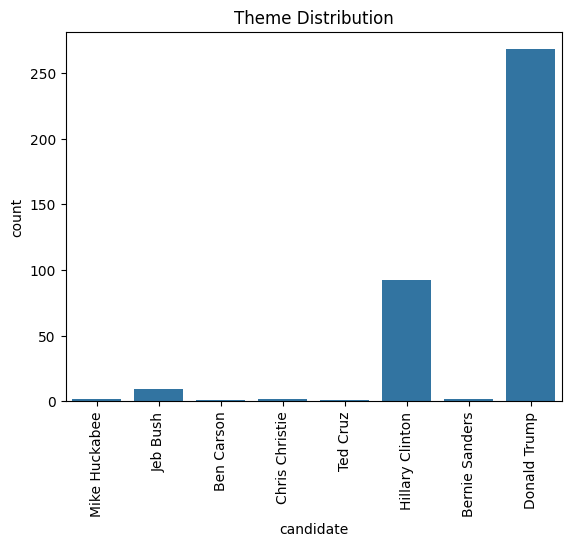

In [66]:
sns.countplot(x='candidate', data=hip_hop)
plt.title('Theme Distribution')
plt.xticks(rotation=90)
plt.show()


In [67]:
hip_hop_subset = hip_hop[['candidate', 'line']]
hip_hop_subset = hip_hop_subset[hip_hop_subset['candidate'].isin(['Donald Trump', 'Hillary Clinton'])]
hip_hop_subset

candidate                                               line
id                                                                     
16   Hillary Clinton  Hillary Clinton ain't gon' like this, she's fa...
17   Hillary Clinton  Until we really saw the true problem / Even Hi...
18   Hillary Clinton  Would you stay down like Hillary? / Even if yo...
19   Hillary Clinton  Makin me call Lewinski / You fuckin up like Hi...
20   Hillary Clinton  Hillary said I frighten her / Alarm go off, ch...
..               ...                                                ...
374     Donald Trump  Bitches got bumps and I'm rich just like Donal...
375     Donald Trump  The world gon' end real soon, especially if Tr...
376     Donald Trump  I've seen more holes than a golf course on Don...
377     Donald Trump                                  Fuck Donald Trump
378     Donald Trump      Boys from the hood call me black Donald Trump

[360 rows x 2 columns]

In [68]:
hip_hop_subset['candidate'].value_counts()

candidate
Donald Trump       268
Hillary Clinton     92
Name: count, dtype: int64

### 3. Text Preprocessing

In [69]:
import nltk
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from gensim.models import Word2Vec


In [70]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [71]:
def remove_stopwords(tokens):
  stop_words = set(stopwords.words('english'))
  return list(filter(lambda x: x not in stop_words, tokens))

In [72]:
def preprocess_lyrics(lyrics):
  result = re.sub(r'\d+', '', lyrics.lower())
  result = re.sub(r'^[^a-zA-Z0-9]+', '', result)

  tokens = word_tokenize(result)
  stop_words = set(stopwords.words('english'))
  tokens_filtered = list(filter(lambda x: x not in stop_words and x.isalpha(), tokens))

  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens_filtered]

  return ' '.join(lemmatized_tokens)

In [73]:
hip_hop_subset['lyrics_processed'] = hip_hop_subset['line'].apply(preprocess_lyrics)
hip_hop_subset

candidate                                               line  \
id                                                                        
16   Hillary Clinton  Hillary Clinton ain't gon' like this, she's fa...   
17   Hillary Clinton  Until we really saw the true problem / Even Hi...   
18   Hillary Clinton  Would you stay down like Hillary? / Even if yo...   
19   Hillary Clinton  Makin me call Lewinski / You fuckin up like Hi...   
20   Hillary Clinton  Hillary said I frighten her / Alarm go off, ch...   
..               ...                                                ...   
374     Donald Trump  Bitches got bumps and I'm rich just like Donal...   
375     Donald Trump  The world gon' end real soon, especially if Tr...   
376     Donald Trump  I've seen more holes than a golf course on Don...   
377     Donald Trump                                  Fuck Donald Trump   
378     Donald Trump      Boys from the hood call me black Donald Trump   

                                      lyrics_processed  
id                                                      
16    hillary clinton ai gon like fanning next serpent  
17       really saw true problem even hilary could rob  
18         would stay like hillary even thought killin  
19              makin call lewinski fuckin like hilary  
20   hillary said frighten alarm go choking teeth w...  
..                                                 ...  
374              bitch got bump rich like donald trump  
375  world gon end real soon especially trump get e...  
376          seen hole golf course donald trump course  
377                                  fuck donald trump  
378                   boy hood call black donald trump  

[360 rows x 3 columns]

### 4. Extract most common k words

In [74]:
def get_freq_dist(candidate):
    all_words = []
    for words in hip_hop_subset[hip_hop_subset['candidate'] == candidate]['lyrics_processed']:
        all_words.extend(words.split(' '))

    return FreqDist(all_words)

In [75]:
def most_common_k_words(candidate, k):
  lst_and_frq = get_freq_dist(candidate).most_common(k)
  return [tup[0] for tup in lst_and_frq]

In [76]:
trump_common = most_common_k_words(candidate='Donald Trump', k=15)
trump_common

['trump',
 'donald',
 'like',
 'tower',
 'get',
 'got',
 'money',
 'fuck',
 'n',
 'ai',
 'bitch',
 'fire',
 'call',
 'shit',
 'man']

In [77]:
clinton_common = most_common_k_words(candidate='Hillary Clinton', k=15)
clinton_common

['hillary',
 'clinton',
 'like',
 'bill',
 'hilary',
 'rodham',
 'bitch',
 'obama',
 'fuck',
 'got',
 'gon',
 'even',
 'call',
 'white',
 'ai']

### 5. Extract Sentiment Scores

In [78]:
trump_clinton = hip_hop_subset

In [79]:
def get_sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

In [80]:
analyzer = SentimentIntensityAnalyzer()
trump_clinton['polarity_scores'] = hip_hop_subset['lyrics_processed'].apply(get_sentiment_score)
trump_clinton

candidate                                               line  \
id                                                                        
16   Hillary Clinton  Hillary Clinton ain't gon' like this, she's fa...   
17   Hillary Clinton  Until we really saw the true problem / Even Hi...   
18   Hillary Clinton  Would you stay down like Hillary? / Even if yo...   
19   Hillary Clinton  Makin me call Lewinski / You fuckin up like Hi...   
20   Hillary Clinton  Hillary said I frighten her / Alarm go off, ch...   
..               ...                                                ...   
374     Donald Trump  Bitches got bumps and I'm rich just like Donal...   
375     Donald Trump  The world gon' end real soon, especially if Tr...   
376     Donald Trump  I've seen more holes than a golf course on Don...   
377     Donald Trump                                  Fuck Donald Trump   
378     Donald Trump      Boys from the hood call me black Donald Trump   

                                      lyrics_processed  polarity_scores  
id                                                                       
16    hillary clinton ai gon like fanning next serpent           0.3612  
17       really saw true problem even hilary could rob          -0.5401  
18         would stay like hillary even thought killin           0.3612  
19              makin call lewinski fuckin like hilary           0.3612  
20   hillary said frighten alarm go choking teeth w...          -0.7783  
..                                                 ...              ...  
374              bitch got bump rich like donald trump           0.3182  
375  world gon end real soon especially trump get e...           0.0000  
376          seen hole golf course donald trump course           0.0000  
377                                  fuck donald trump          -0.5423  
378                   boy hood call black donald trump           0.0000  

[360 rows x 4 columns]

In [81]:
trump_clinton_nonzero = trump_clinton[trump_clinton['polarity_scores'] != 0]
trump_clinton_nonzero

candidate                                               line  \
id                                                                        
16   Hillary Clinton  Hillary Clinton ain't gon' like this, she's fa...   
17   Hillary Clinton  Until we really saw the true problem / Even Hi...   
18   Hillary Clinton  Would you stay down like Hillary? / Even if yo...   
19   Hillary Clinton  Makin me call Lewinski / You fuckin up like Hi...   
20   Hillary Clinton  Hillary said I frighten her / Alarm go off, ch...   
..               ...                                                ...   
368     Donald Trump                It's fuck all you n----s like Trump   
371     Donald Trump  Where I stay all they say is Fuck Trump۝, all day   
373     Donald Trump                             Feel like Donald Trump   
374     Donald Trump  Bitches got bumps and I'm rich just like Donal...   
377     Donald Trump                                  Fuck Donald Trump   

                                      lyrics_processed  polarity_scores  
id                                                                       
16    hillary clinton ai gon like fanning next serpent           0.3612  
17       really saw true problem even hilary could rob          -0.5401  
18         would stay like hillary even thought killin           0.3612  
19              makin call lewinski fuckin like hilary           0.3612  
20   hillary said frighten alarm go choking teeth w...          -0.7783  
..                                                 ...              ...  
368                                  fuck n like trump          -0.2500  
371                                  stay say fuck day          -0.5423  
373                             feel like donald trump           0.3612  
374              bitch got bump rich like donald trump           0.3182  
377                                  fuck donald trump          -0.5423  

[215 rows x 4 columns]

In [82]:
trump_clinton_nonzero[['candidate', 'polarity_scores']].groupby('candidate').describe()

polarity_scores                                        \
                          count      mean       std     min       25%   
candidate                                                               
Donald Trump              155.0  0.008965  0.462855 -0.8720 -0.510300   
Hillary Clinton            60.0 -0.050663  0.575941 -0.9371 -0.589275   

                                          
                     50%     75%     max  
candidate                                 
Donald Trump     0.12800  0.3612  0.8020  
Hillary Clinton  0.07715  0.3612  0.9081

### 6. Visualization

#### Histogram

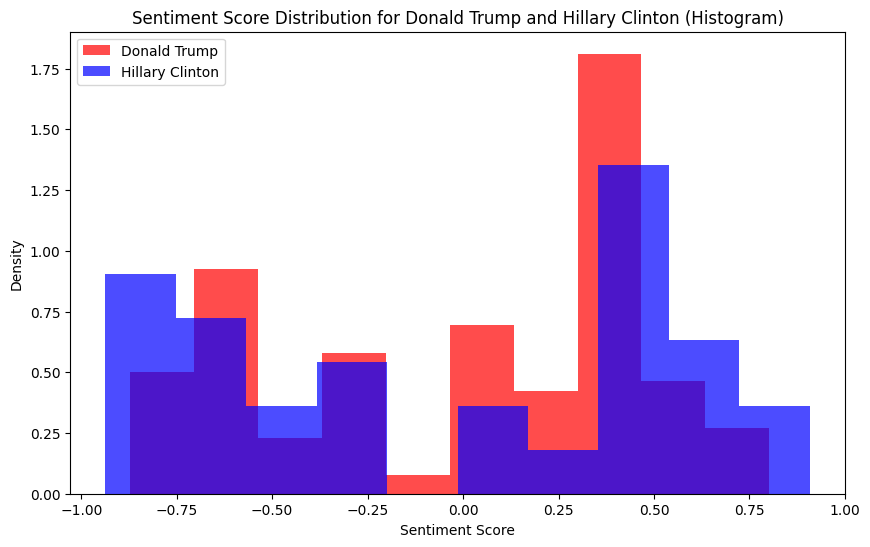

In [83]:
plt.figure(figsize=(10, 6))
trump_scores, clinton_scores = trump_clinton_nonzero[trump_clinton_nonzero['candidate'] == 'Donald Trump']['polarity_scores'], trump_clinton_nonzero[trump_clinton_nonzero['candidate'] == 'Hillary Clinton']['polarity_scores']
plt.hist(trump_scores, label='Donald Trump', color='red', alpha=0.7, density=True)
plt.hist(clinton_scores, label='Hillary Clinton', color='blue', alpha=0.7, density=True)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Sentiment Score Distribution for Donald Trump and Hillary Clinton (Histogram)')
plt.legend(loc='upper left')

#### Boxplot

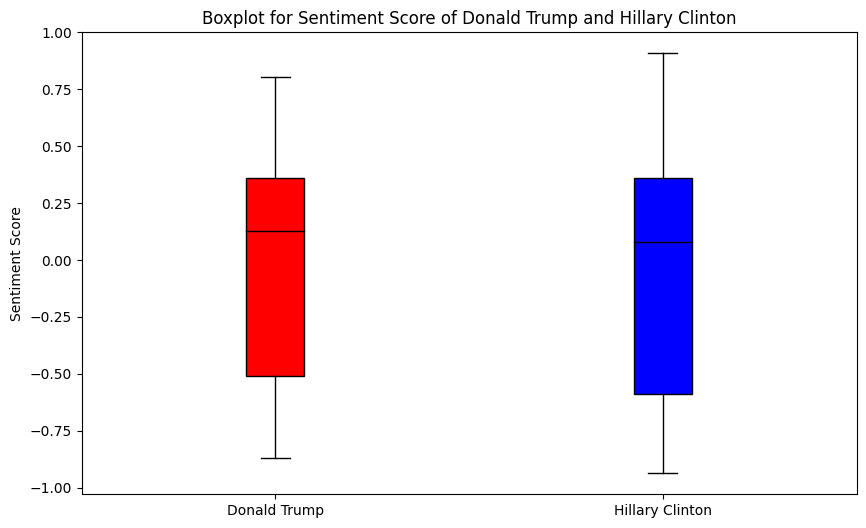

In [84]:
polarity_scores = [trump_scores, clinton_scores]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(polarity_scores, patch_artist=True, medianprops=dict(color='black'))

colors = ['red', 'blue']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks([1, 2], ['Donald Trump', 'Hillary Clinton'])

plt.title('Boxplot for Sentiment Score of Donald Trump and Hillary Clinton')
plt.ylabel('Sentiment Score')

# Show plot
plt.show()